# Dogs vs. Cats, CNN

## パッケージ群のインポート

In [100]:
import tensorflow
from tensorflow import keras
%matplotlib inline
import matplotlib.pyplot as plt

In [101]:
import os, cv2, random
import numpy as np
import pandas as pd

In [102]:
from matplotlib import ticker
import seaborn as sns

## トレーニング・テストデータの作成

In [103]:
TRAIN_DIR = "./train/"  # 同じディレクトリに画像データを格納しているため
TEST_DIR = "./test/"

In [104]:
ROWS = 64
COLS = 64
CHANNELS = 3

In [105]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]

In [106]:
train_images[:10]  # 出力結果を確認後、コピーのため省略

['./train/cat.0.jpg',
 './train/cat.1.jpg',
 './train/cat.10.jpg',
 './train/cat.100.jpg',
 './train/cat.1000.jpg',
 './train/cat.10000.jpg',
 './train/cat.10001.jpg',
 './train/cat.10002.jpg',
 './train/cat.10003.jpg',
 './train/cat.10004.jpg']

In [107]:
len(train_images)

25000

In [108]:
train_images[1000]

'./train/cat.10898.jpg'

### リストの内包表記

In [109]:
# train_dogs = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]

In [110]:
# train_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

In [111]:
# len(train_dogs)

In [112]:
# len(train_cats)

In [113]:
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [114]:
len(test_images)

12500

In [115]:
test_images[:10]

['./test/1.jpg',
 './test/10.jpg',
 './test/100.jpg',
 './test/1000.jpg',
 './test/10000.jpg',
 './test/10001.jpg',
 './test/10002.jpg',
 './test/10003.jpg',
 './test/10004.jpg',
 './test/10005.jpg']

### リストのスライス処理、提出用は全データ

In [116]:
# train_images = train_dogs[:1000] + train_cats[:1000]
# train_images = train_dogs + train_cats

In [117]:
# len(train_images)

25000

In [118]:
# random.shuffle(train_images)

In [119]:
# test_images =  test_images[:25]

In [120]:
# len(test_images)

### 画像ファイルを多次元配列に変換

In [121]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

In [122]:
def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)
    
    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T #transpose mxn > nxm
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
            
    return data
        

In [123]:
train = prep_data(train_images)
test = prep_data(test_images)

Processed 0 of 25000


Processed 250 of 25000


Processed 500 of 25000


Processed 750 of 25000


Processed 1000 of 25000


Processed 1250 of 25000


Processed 1500 of 25000


Processed 1750 of 25000


Processed 2000 of 25000


Processed 2250 of 25000


Processed 2500 of 25000


Processed 2750 of 25000


Processed 3000 of 25000


Processed 3250 of 25000


Processed 3500 of 25000


Processed 3750 of 25000


Processed 4000 of 25000


Processed 4250 of 25000


Processed 4500 of 25000


Processed 4750 of 25000


Processed 5000 of 25000


Processed 5250 of 25000


Processed 5500 of 25000


Processed 5750 of 25000


Processed 6000 of 25000


Processed 6250 of 25000


Processed 6500 of 25000


Processed 6750 of 25000


Processed 7000 of 25000


Processed 7250 of 25000


Processed 7500 of 25000


Processed 7750 of 25000


Processed 8000 of 25000


Processed 8250 of 25000


Processed 8500 of 25000


Processed 8750 of 25000


Processed 9000 of 25000


Processed 9250 of 25000


Processed 9500 of 25000


Processed 9750 of 25000


Processed 10000 of 25000


Processed 10250 of 25000


Processed 10500 of 25000


Processed 10750 of 25000


Processed 11000 of 25000


Processed 11250 of 25000


Processed 11500 of 25000


Processed 11750 of 25000


Processed 12000 of 25000


Processed 12250 of 25000


Processed 12500 of 25000


Processed 12750 of 25000


Processed 13000 of 25000


Processed 13250 of 25000


Processed 13500 of 25000


Processed 13750 of 25000


Processed 14000 of 25000


Processed 14250 of 25000


Processed 14500 of 25000


Processed 14750 of 25000


Processed 15000 of 25000


Processed 15250 of 25000


Processed 15500 of 25000


Processed 15750 of 25000


Processed 16000 of 25000


Processed 16250 of 25000


Processed 16500 of 25000


Processed 16750 of 25000


Processed 17000 of 25000


Processed 17250 of 25000


Processed 17500 of 25000


Processed 17750 of 25000


Processed 18000 of 25000


Processed 18250 of 25000


Processed 18500 of 25000


Processed 18750 of 25000


Processed 19000 of 25000


Processed 19250 of 25000


Processed 19500 of 25000


Processed 19750 of 25000


Processed 20000 of 25000


Processed 20250 of 25000


Processed 20500 of 25000


Processed 20750 of 25000


Processed 21000 of 25000


Processed 21250 of 25000


Processed 21500 of 25000


Processed 21750 of 25000


Processed 22000 of 25000


Processed 22250 of 25000


Processed 22500 of 25000


Processed 22750 of 25000


Processed 23000 of 25000


Processed 23250 of 25000


Processed 23500 of 25000


Processed 23750 of 25000


Processed 24000 of 25000


Processed 24250 of 25000


Processed 24500 of 25000


Processed 24750 of 25000


Processed 0 of 12500


Processed 250 of 12500


Processed 500 of 12500


Processed 750 of 12500


Processed 1000 of 12500


Processed 1250 of 12500


Processed 1500 of 12500


Processed 1750 of 12500


Processed 2000 of 12500


Processed 2250 of 12500


Processed 2500 of 12500


Processed 2750 of 12500


Processed 3000 of 12500


Processed 3250 of 12500


Processed 3500 of 12500


Processed 3750 of 12500


Processed 4000 of 12500


Processed 4250 of 12500


Processed 4500 of 12500


Processed 4750 of 12500


Processed 5000 of 12500


Processed 5250 of 12500


Processed 5500 of 12500


Processed 5750 of 12500


Processed 6000 of 12500


Processed 6250 of 12500


Processed 6500 of 12500


Processed 6750 of 12500


Processed 7000 of 12500


Processed 7250 of 12500


Processed 7500 of 12500


Processed 7750 of 12500


Processed 8000 of 12500


Processed 8250 of 12500


Processed 8500 of 12500


Processed 8750 of 12500


Processed 9000 of 12500


Processed 9250 of 12500


Processed 9500 of 12500


Processed 9750 of 12500


Processed 10000 of 12500


Processed 10250 of 12500


Processed 10500 of 12500


Processed 10750 of 12500


Processed 11000 of 12500


Processed 11250 of 12500


Processed 11500 of 12500


Processed 11750 of 12500


Processed 12000 of 12500


Processed 12250 of 12500


In [124]:
train.shape

(25000, 3, 64, 64)

In [125]:
test.shape

(12500, 3, 64, 64)

### ラベル一覧をリスト型変数に格納 train用label作成

In [126]:
labels = []
for i in train_images:
    if 'dog.' in i:
        labels.append(1)
    else:
        labels.append(0)

In [127]:
labels[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [128]:
train_images[0:10]

['./train/cat.0.jpg',
 './train/cat.1.jpg',
 './train/cat.10.jpg',
 './train/cat.100.jpg',
 './train/cat.1000.jpg',
 './train/cat.10000.jpg',
 './train/cat.10001.jpg',
 './train/cat.10002.jpg',
 './train/cat.10003.jpg',
 './train/cat.10004.jpg']

Text(0.5, 1.0, 'Cats and Dogs')

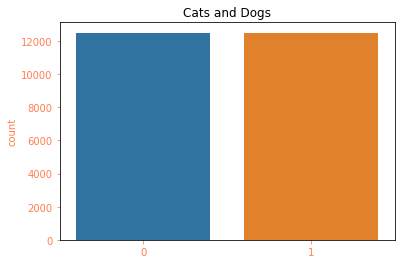

In [129]:
sns.countplot(labels)
plt.title('Cats and Dogs')

### 画像データの確認

In [130]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10, 5))
    plt.imshow(pair)
    plt.show()

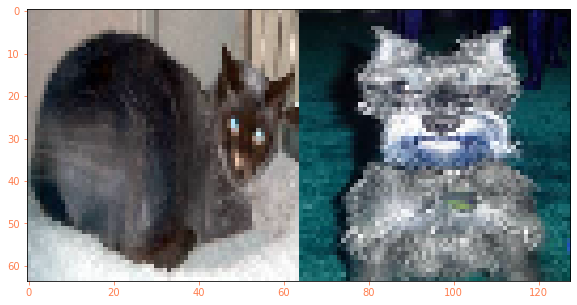

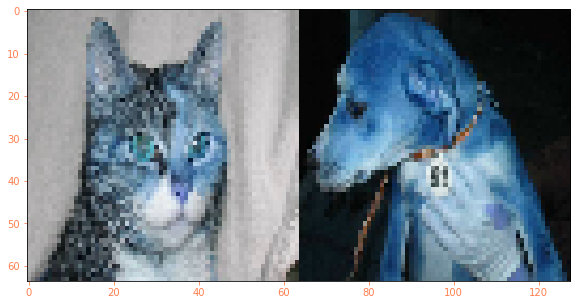

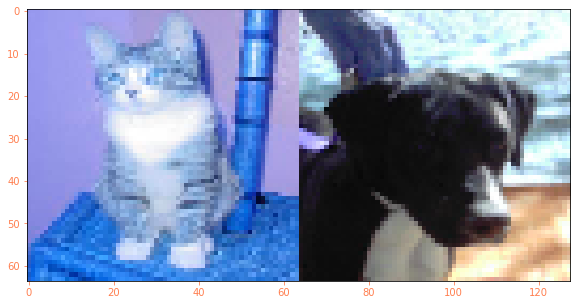

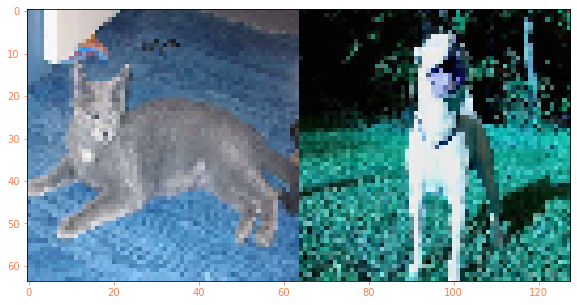

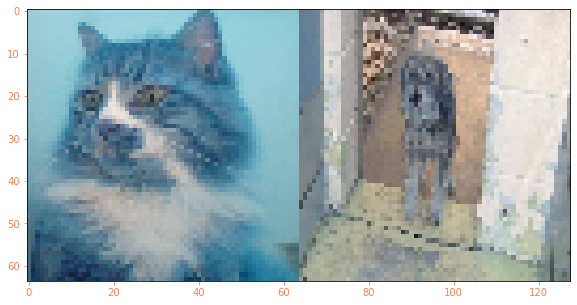

In [131]:
for idx in range(10, 15):
    show_cats_and_dogs(idx)

### ピクセル値を平均して画像を生成する

Text(0.5, 1.0, 'Your Average Dog')

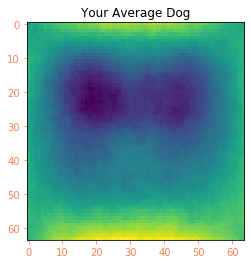

In [132]:
dog_avg = np.array([dog[0].T for i, dog in enumerate(train) if labels[i]==1]).mean(axis=0)
plt.imshow(dog_avg)
plt.title('Your Average Dog')


Text(0.5, 1.0, 'Your Average Cat')

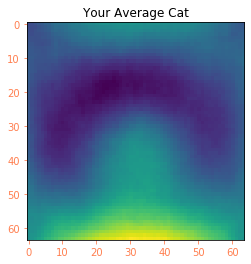

In [133]:
cat_avg = np.array([cat[0].T for i, cat in enumerate(train) if labels[i]==0]).mean(axis=0)
plt.imshow(cat_avg)
plt.title('Your Average Cat')

### CatdogNet-16 の定義

In [134]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
# from tensorflow.keras.utils import np_utils

In [135]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog()



### トレーニングの実行

In [136]:
nb_epoch = 10
batch_size = 16


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# monitor: 監視対象
# patience: 訓練が停止し，値が改善しなくなってからのエポック数．
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')


def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    
    predictions = model.predict(test, verbose=0)
    return predictions, history


predictions, history = run_catdog()
# タプルで受け取る


Epoch 00006: early stopping


### ロスをプロットしよう

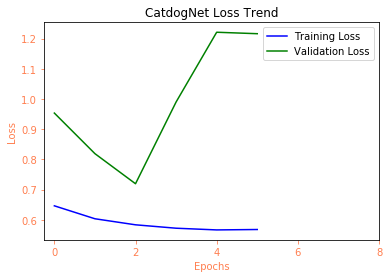

In [138]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('CatdogNet Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0, nb_epoch)[0::2])
plt.legend()
plt.show()

### 推定結果を可視化

I am 83.27% sure this is a Cat


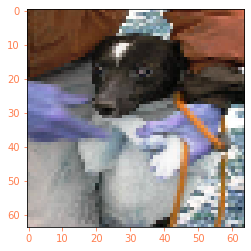

I am 92.72% sure this is a Cat


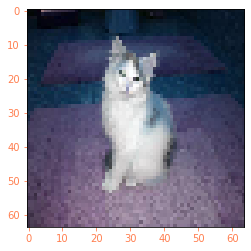

I am 91.23% sure this is a Cat


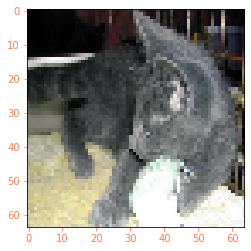

I am 79.21% sure this is a Cat


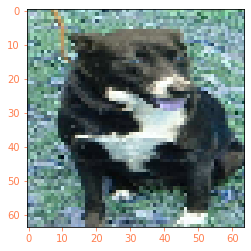

I am 58.89% sure this is a Cat


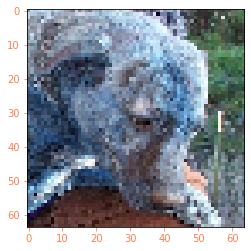

I am 97.00% sure this is a Cat


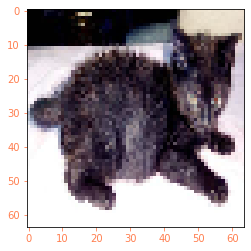

I am 78.33% sure this is a Cat


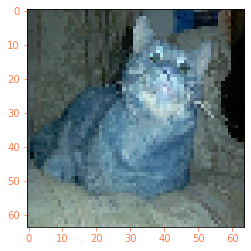

I am 51.14% sure this is a Cat


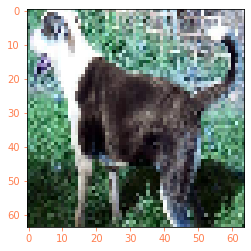

I am 77.75% sure this is a Cat


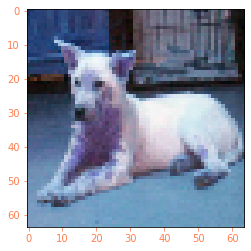

I am 82.85% sure this is a Cat


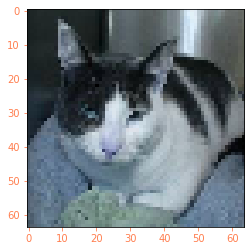

In [139]:
for i in range(0, 10):
    if predictions[i, 0] >= 0.5:
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else:
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()

In [74]:
# import csv
# 
# with open('dogscats_pred.csv','w') as f:
# 
#       writer=csv.writer(f,lineterminator='\n')
#       writer.writerows(predictions)
#       
# 
# 
# submit["id"] = pd.DataFrame(np.arange(12500))
# submit["label"] = predictions
# submit = submit[["id", "label"]]
# submit.head()

import re

sub = re.sub(r'\D', '', test_images)
sub>head

,id,label
0,0,0.285820
1,1,0.227091
2,2,0.181314
3,3,0.358415
4,4,0.342541


In [76]:
submit.to_csv("submit.csv")